# Performance as well as Validation benchmarks for activation function implementations in the different frameworks

# CPU versions only

Windows 11
i7 11800H
Nvidia 3050 Ti

I used 

`conda install 'tensorflow=*=mkl*'`
and 

`conda install pytorch torchvision torchaudio cpuonly -c pytorch`

`pip install crysx_nn`

## Run the following for Google colab 
then restart runtime

In [1]:
! pip install --upgrade --no-cache-dir https://github.com/manassharma07/crysx_nn/tarball/main
! pip install IPython==7.7.0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Ensure that evertyhing is only using CPU¶

import numpy as np
np.show_config()
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import ReLU, ReLU_grad
from crysx_nn.activation import Softplus, Softplus_grad
from crysx_nn.activation import Identity, Identity_grad
from crysx_nn.activation import Tanh, Tanh_grad

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [6]:
X_torch = torch.rand((300,100),requires_grad=True)
print(X_torch)

tensor([[0.1874, 0.6848, 0.5594,  ..., 0.5079, 0.6957, 0.5004],
        [0.9746, 0.4435, 0.9929,  ..., 0.2895, 0.5224, 0.1098],
        [0.1589, 0.1252, 0.3177,  ..., 0.3456, 0.5717, 0.3268],
        ...,
        [0.9077, 0.1951, 0.2282,  ..., 0.1042, 0.0399, 0.0219],
        [0.7230, 0.4775, 0.5205,  ..., 0.6408, 0.8336, 0.2234],
        [0.8041, 0.4591, 0.3953,  ..., 0.9199, 0.9188, 0.4926]],
       requires_grad=True)


## Convert it to numpy for `crysx_nn`

In [7]:
X_crysx_nn = X_torch.cpu().detach().numpy()
print(X_crysx_nn.dtype)

float32


## Now finally convert it to a tensorflow tensor

In [8]:
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

## Benchmark ReLU

### Confirm that all frameworks give the same results

In [9]:
# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)

# CrysX
relu_crysx_nn_value = ReLU(X_crysx_nn)

# Tensorflow
relu_tf_value = tf.nn.relu(X_tf)#tf.keras.activations.relu(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(relu_torch_value.cpu().detach().numpy() - relu_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(relu_torch_value.cpu().detach().numpy() - relu_crysx_nn_value).max())

Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

In [10]:
# Torch
print('PyTorch')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 relu_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 ReLU(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.keras.activations.relu(X_tf)


PyTorch
14.2 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
4.46 µs ± 125 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
6.04 µs ± 139 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [11]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o relu_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o ReLU(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    with tf.device("cpu:0"):
        time = %timeit -n 500 -o tf.nn.relu(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

5.21 µs ± 543 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
790 ns ± 49.1 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.66 µs ± 377 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
26.6 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
39.9 µs ± 1e+03 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
39.8 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
610 µs ± 51.5 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
893 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
876 µs ± 47.1 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.3 ms ± 87 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.93 ms ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.36 ms ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.11 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.38 ms ± 46.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2

### Plot the results

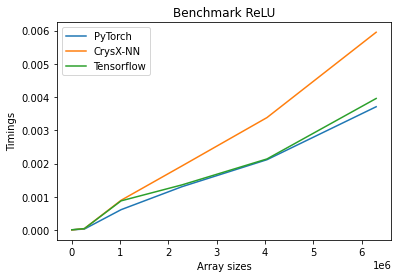

In [12]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark ReLU')
plt.show()

## Benchmark ReLU derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [13]:
def tf_relu_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        relu_values = tf.nn.relu(x)
    grad = g.gradient(relu_values, x)
    return grad#.numpy()

In [14]:
def torch_relu_grad(relu_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=relu_values, inputs=x,
                          grad_outputs=torch.ones(relu_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [15]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
gradientsTorch = torch_relu_grad(relu_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = ReLU_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_relu_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
gradientsTF = g.gradient(relu_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of ReLU gradients that I have used, are a good representative of the real-world performance or not. 


So we would skip the plots of timings vs array_size for benchmarks.

In [16]:
# Torch
print('PyTorch gradient only')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
%timeit -n 100 torch_relu_grad(relu_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 ReLU_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_relu_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.relu(X_tf)


PyTorch gradient only
1.25 ms ± 92.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
1.03 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
2.66 ms ± 76.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
1.07 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Sigmoid

### Confirm that all frameworks give the same results

In [17]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)

# CrysX
sigmoid_crysx_nn_value = Sigmoid(X_crysx_nn)


# Tensorflow
sigmoid_tf_value = tf.keras.activations.sigmoid(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_crysx_nn_value).max())


Max abs diff b/w torch and tf 1.1920929e-07
Max abs diff b/w torch and CrysX 5.9604645e-08


### Compare performance

In [18]:
# Torch
print('PyTorch')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
%timeit -n 100 sigmoid_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Sigmoid(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)


PyTorch
1.77 ms ± 54.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
1.97 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
995 µs ± 52.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [19]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = 1000*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o sigmoid_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Sigmoid(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.sigmoid(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

8.34 µs ± 458 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
56.3 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.47 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.13 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.83 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
81.1 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.2 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.12 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.01 ms ± 92.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.9 ms ± 638 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.2 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.59 ms ± 65.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.8 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3

### Plot the results

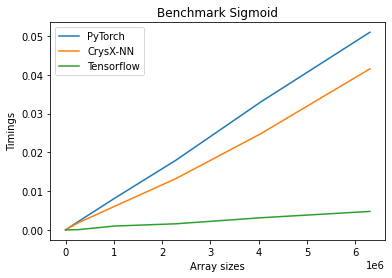

In [20]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Sigmoid')
plt.show()


## Benchmark Sigmoid derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [21]:
def tf_sigmoid_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        sigmoid_values = tf.nn.sigmoid(x)
    grad = g.gradient(sigmoid_values, x)
    return grad#.numpy()

In [22]:
def torch_sigmoid_grad(sigmoid_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=sigmoid_values, inputs=x,
                          grad_outputs=torch.ones(sigmoid_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [23]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
gradientsTorch = torch_sigmoid_grad(sigmoid_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Sigmoid_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_sigmoid_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
gradientsTF = g.gradient(sigmoid_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 5.9604645e-08
Max abs diff b/w torch and CrysX 4.4703484e-08


### Compare performance

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of Sigmoid gradients that I have used, are a good representative of the real-world performance or not. 


So we would skip the plots of timings vs array_size for benchmarks.

In [24]:
# Torch
print('PyTorch gradient only')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
%timeit -n 100 torch_sigmoid_grad(sigmoid_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Sigmoid_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
# %timeit -n 100 g.gradient(sigmoid_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_sigmoid_grad(X_tf)
print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)



PyTorch gradient only
1.97 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
2.96 ms ± 570 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
3.42 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
1.35 ms ± 71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast for a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Softmax

### Confirm that all frameworks give the same results

In [25]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)

# CrysX
softmax_crysx_nn_value = Softmax(X_crysx_nn)

# Tensorflow
softmax_tf_value = tf.keras.activations.softmax(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(softmax_torch_value.cpu().detach().numpy() - softmax_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(softmax_torch_value.cpu().detach().numpy() - softmax_crysx_nn_value).max())


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Max abs diff b/w torch and tf 2.3283064e-09
Max abs diff b/w torch and CrysX 2.4447218e-09


### Compare performance

In [26]:
# Torch
print('PyTorch')
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
%timeit -n 100 softmax_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Softmax(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.softmax(X_tf)


PyTorch


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


2.3 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
5.24 ms ± 784 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
1.72 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [27]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,2500,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    softmax_torch_func = torch.nn.Softmax() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o softmax_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Softmax(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.softmax(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

20.2 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.85 µs ± 691 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 µs ± 5.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


589 µs ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
805 µs ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
236 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.68 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.41 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.2 ms ± 35.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.4 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.18 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.49 ms ± 581 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.3 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.27 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Plot the results

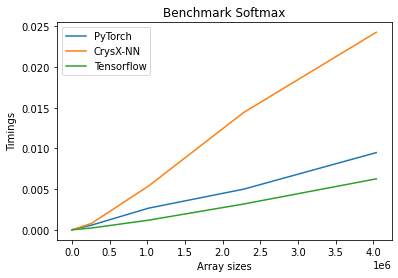

In [28]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Softmax')
plt.show()


## Benchmark Softmax derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function.

Therefore, it is not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

#### Update: Seems to be really problematic to get the jacobian of Softmax wrt inputs in an efficient manner using the PyTorch framework. 

There are ways in which you can do it, but they would be slow. (https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16)

So take the timing results with a grain of salt.

In [29]:
def tf_softmax_grad(z):
#   z = tf.constant(z, dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(z)
        a = tf.nn.softmax(z) 
    jacob = g.batch_jacobian(a, z)
    return jacob#.numpy()

In [30]:
# Reference: https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16
def torch_softmax_grad(wrt):
    jacobian = []
    softmax_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
    softmax_func.eval()
    for i in range(wrt.shape[0]):
        jac = torch.autograd.functional.jacobian(softmax_func, wrt[i])
        jacobian.append(jac)
        #
    return torch.stack(jacobian, 0)

### Confirm that all frameworks give the same results

In [31]:
# Torch input
X_torch = torch.rand((100,100),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
# softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)
device = 'cpu'
gradientsTorch = torch_softmax_grad(X_torch)#torch.autograd.grad(outputs=softmax_torch_value, inputs=X_torch,
#                           grad_outputs=torch.ones(softmax_torch_value.size()).to(device),
#                           create_graph=True, retain_graph=True, only_inputs=True)[0]
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Softmax_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
# softmax_tf_value = tf.nn.softmax(X_tf)
gradientsTF = tf_softmax_grad(X_tf)
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\torch\autograd\functional.py:482: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = func(*inputs)


Max abs diff b/w torch and tf 6.519258e-09
Max abs diff b/w torch and CrysX 9.313226e-09


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [32]:
# Torch
print('PyTorch')
%timeit -n 10 torch_softmax_grad(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 10 Softmax_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 10 tf_softmax_grad(X_tf)


PyTorch


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\torch\autograd\functional.py:482: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = func(*inputs)


310 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
CrysX-NN (crysx_nn)
3.75 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Tensorflow
239 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Benchmark Tanh

### Confirm that all frameworks give the same results

In [33]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
tanh_torch_func = torch.nn.Tanh() # Get an instance of ReLU class for Pytorch
tanh_torch_value = tanh_torch_func(X_torch)

# CrysX
tanh_crysx_nn_value = Tanh(X_crysx_nn)

# Tensorflow
tanh_tf_value = tf.nn.tanh(X_tf)#tf.keras.activations.relu(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(tanh_torch_value.cpu().detach().numpy() - tanh_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(tanh_torch_value.cpu().detach().numpy() - tanh_crysx_nn_value).max())

Max abs diff b/w torch and tf 1.7881393e-07
Max abs diff b/w torch and CrysX 5.9604645e-08


### Compare performance

In [34]:
# Torch
print('PyTorch')
tanh_torch_func = torch.nn.Tanh() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 tanh_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 Tanh(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.keras.activations.tanh(X_tf)


PyTorch
657 µs ± 134 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
1.87 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
979 µs ± 128 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [35]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    tanh_torch_func = torch.nn.Tanh() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o tanh_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o Tanh(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    with tf.device("cpu:0"):
        time = %timeit -n 500 -o tf.nn.tanh(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

5.17 µs ± 782 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.29 µs ± 40.9 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.97 µs ± 231 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
37.4 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
376 µs ± 8.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
59.7 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
733 µs ± 111 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.91 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
922 µs ± 93.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.39 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.86 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.54 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.9 ms ± 606 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
8.02 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.93 

### Plot the results

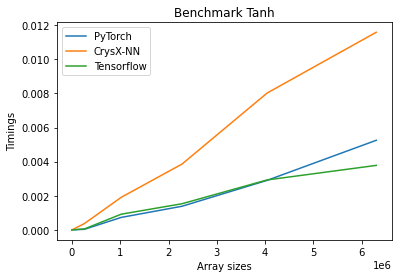

In [36]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Tanh')
plt.show()

## Benchmark Tanh derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [37]:
def tf_tanh_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        tanh_values = tf.nn.tanh(x)
    grad = g.gradient(tanh_values, x)
    return grad#.numpy()

In [38]:
def torch_tanh_grad(tanh_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=tanh_values, inputs=x,
                          grad_outputs=torch.ones(tanh_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [39]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
tanh_torch_func = torch.nn.Tanh() # Get an instance of ReLU class for Pytorch
tanh_torch_value = tanh_torch_func(X_torch)
gradientsTorch = torch_tanh_grad(tanh_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Tanh_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_tanh_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    tanh_tf_value = tf.nn.tanh(X_tf)
gradientsTF = g.gradient(tanh_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 2.9802322e-07
Max abs diff b/w torch and CrysX 1.1920928955078125e-07


### Compare performance

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of Tanh gradients that I have used, are a good representative of the real-world performance or not. 


So we would skip the plots of timings vs array_size for benchmarks.

In [40]:
# Torch
print('PyTorch gradient only')
tanh_torch_func = torch.nn.Tanh() # Get an instance of ReLU class for Pytorch
tanh_torch_value = tanh_torch_func(X_torch)
%timeit -n 100 torch_tanh_grad(tanh_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Tanh_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    tanh_tf_value = tf.nn.tanh(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_tanh_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.tanh(X_tf)


PyTorch gradient only
1.24 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
2.37 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
2.72 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
821 µs ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Identity

### Confirm that all frameworks give the same results

In [41]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
identity_torch_func = torch.nn.Identity() # Get an instance of ReLU class for Pytorch
identity_torch_value = identity_torch_func(X_torch)

# CrysX
identity_crysx_nn_value = Identity(X_crysx_nn)

# Tensorflow
identity_tf_value = tf.identity(X_tf)#tf.keras.activations.relu(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(identity_torch_value.cpu().detach().numpy() - identity_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(identity_torch_value.cpu().detach().numpy() - identity_crysx_nn_value).max())

Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

In [42]:
# Torch
print('PyTorch')
identity_torch_func = torch.nn.Identity() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 identity_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 Identity(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.identity(X_tf)


PyTorch
530 ns ± 3.26 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
450 ns ± 16.2 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
5.15 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [43]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    identity_torch_func = torch.nn.Identity() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o identity_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o Identity(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    with tf.device("cpu:0"):
        time = %timeit -n 500 -o tf.identity(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

551 ns ± 19.8 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
474 ns ± 14.2 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
7.23 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
519 ns ± 2.75 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
438 ns ± 5.26 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
5.22 µs ± 402 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
542 ns ± 2.95 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
452 ns ± 2.81 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
5.28 µs ± 54.9 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
656 ns ± 122 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
485 ns ± 46.8 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
5.4 µs ± 148 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
558 ns ± 14.3 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
532 ns ± 154 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
5.34 µs

### Plot the results

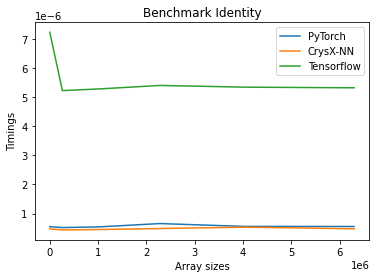

In [44]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Identity')
plt.show()

## Benchmark Identity derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [45]:
def tf_identity_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        identity_values = tf.identity(x)
    grad = g.gradient(identity_values, x)
    return grad#.numpy()

In [46]:
def torch_identity_grad(identity_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=identity_values, inputs=x,
                          grad_outputs=torch.ones(identity_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [47]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
identity_torch_func = torch.nn.Identity() # Get an instance of ReLU class for Pytorch
identity_torch_value = identity_torch_func(X_torch)
gradientsTorch = torch_identity_grad(identity_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Identity_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_identity_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    identity_tf_value = tf.identity(X_tf)
gradientsTF = g.gradient(identity_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of Identity gradients that I have used, are a good representative of the real-world performance or not. 


So we would skip the plots of timings vs array_size for benchmarks.

In [48]:
# Torch
print('PyTorch gradient only')
identity_torch_func = torch.nn.Identity() # Get an instance of ReLU class for Pytorch
identity_torch_value = identity_torch_func(X_torch)
%timeit -n 100 torch_identity_grad(identity_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Identity_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    identity_tf_value = tf.identity(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_identity_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.identity(X_tf)


PyTorch gradient only
548 µs ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
1.56 ms ± 97.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
952 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
5.69 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Softplus

### Confirm that all frameworks give the same results

In [49]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
softplus_torch_func = torch.nn.Softplus() # Get an instance of ReLU class for Pytorch
softplus_torch_value = softplus_torch_func(X_torch)

# CrysX
softplus_crysx_nn_value = Softplus(X_crysx_nn)

# Tensorflow
softplus_tf_value = tf.nn.softplus(X_tf)#tf.keras.activations.relu(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(softplus_torch_value.cpu().detach().numpy() - softplus_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(softplus_torch_value.cpu().detach().numpy() - softplus_crysx_nn_value).max())

Max abs diff b/w torch and tf 1.1920929e-07
Max abs diff b/w torch and CrysX 1.1920929e-07


### Compare performance

In [50]:
# Torch
print('PyTorch')
softplus_torch_func = torch.nn.Softplus() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 softplus_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 Softplus(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.keras.activations.softplus(X_tf)


PyTorch
3.66 ms ± 89.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
1.89 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
1.09 ms ± 78.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [51]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,2500,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    softplus_torch_func = torch.nn.Softplus() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o softplus_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o Softplus(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    with tf.device("cpu:0"):
        time = %timeit -n 500 -o tf.nn.softplus(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

8.55 µs ± 862 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.33 µs ± 31.8 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
5.06 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
897 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
428 µs ± 49.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
183 µs ± 5.04 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.84 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.99 ms ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.05 ms ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
8.66 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
4.5 ms ± 88.1 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.21 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
15 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
8.82 ms ± 973 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
3.5

### Plot the results

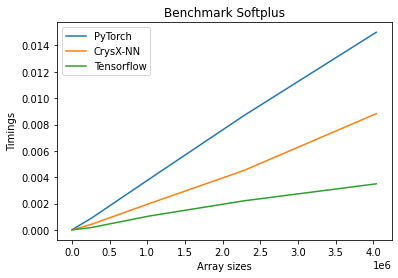

In [52]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Softplus')
plt.show()

## Benchmark Softplus derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [53]:
def tf_softplus_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        softplus_values = tf.nn.softplus(x)
    grad = g.gradient(softplus_values, x)
    return grad#.numpy()

In [54]:
def torch_softplus_grad(softplus_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=softplus_values, inputs=x,
                          grad_outputs=torch.ones(softplus_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [55]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
softplus_torch_func = torch.nn.Softplus() # Get an instance of ReLU class for Pytorch
softplus_torch_value = softplus_torch_func(X_torch)
gradientsTorch = torch_softplus_grad(softplus_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Softplus_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_softplus_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    softplus_tf_value = tf.nn.softplus(X_tf)
gradientsTF = g.gradient(softplus_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 1.1920929e-07
Max abs diff b/w torch and CrysX 1.0873321476534414e-07


### Compare performance

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of Softplus gradients that I have used, are a good representative of the real-world performance or not. 


So we would skip the plots of timings vs array_size for benchmarks.

In [56]:
# Torch
print('PyTorch gradient only')
softplus_torch_func = torch.nn.Softplus() # Get an instance of ReLU class for Pytorch
softplus_torch_value = softplus_torch_func(X_torch)
%timeit -n 100 torch_softplus_grad(softplus_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Softplus_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    softplus_tf_value = tf.nn.softplus(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_softplus_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.softplus(X_tf)


PyTorch gradient only
2.38 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
2.01 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
3.85 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
1.1 ms ± 63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.